# hw07

In [5]:
#数据
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

In [10]:
data = pd.read_csv('data/stock_px.csv', index_col=0)

In [11]:
data.head()

,AAPL,MSFT,XOM,SPX
2003-01-02 00:00:00,7.40,21.11,29.22,909.03
2003-01-03 00:00:00,7.45,21.14,29.24,908.59
2003-01-06 00:00:00,7.45,21.52,29.96,929.01
2003-01-07 00:00:00,7.43,21.93,28.95,922.93
2003-01-08 00:00:00,7.28,21.31,28.83,909.93


In [12]:
symbols = data.columns.tolist()
noa = len(symbols)

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


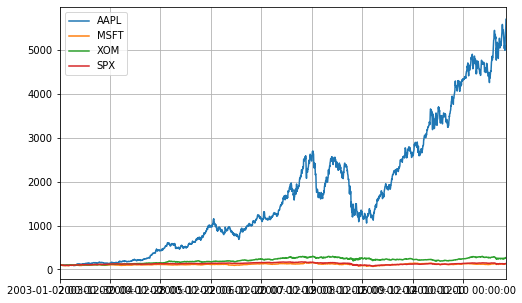

In [13]:
(data / data.ix[0] * 100).plot(figsize=(8, 5), grid=True)

In [14]:
rets = np.log(data / data.shift(1))

In [16]:
rets.mean() * 252  # 年化收益

AAPL    0.460447
MSFT    0.029156
XOM     0.111967
SPX     0.033931
dtype: float64

In [17]:
rets.cov() * 252  # 协方差

,AAPL,MSFT,XOM,SPX
AAPL,0.150288,0.048609,0.039699,0.047065
MSFT,0.048609,0.078788,0.039356,0.042821
XOM,0.039699,0.039356,0.070137,0.043358
SPX,0.047065,0.042821,0.043358,0.045852


## 随机初始化组合权重

In [18]:
#基本理论
weights = np.random.random(noa)
weights /= np.sum(weights)

weights

array([0.4241986 , 0.32889275, 0.00314559, 0.24376306])

In [19]:
np.sum(rets.mean() * weights) * 252  # 组合年化收益

0.2135333745618022

In [20]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))  # 组合年化方差

0.06870799065387012

In [21]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))  # 组合年化标准差

0.26212209112142787

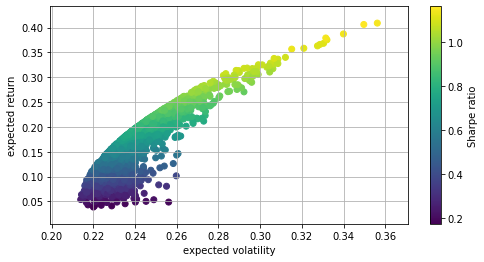

In [22]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [23]:
#投资组合优化
def statistics(weights,rf=0):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, (pret-rf) / pvol])

import scipy.optimize as sco

def min_func_sharpe(weights):
    return -statistics(weights)[2]

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

bnds = tuple((0, 1) for x in range(noa))

noa * [1. / noa,]  # 初始化 每个股票的权重 平均

[0.25, 0.25, 0.25, 0.25]

In [25]:
get_ipython().run_cell_magic(u'time', u'', \
                             u"opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',\n  bounds=bnds, constraints=cons)")

CPU times: user 33.9 ms, sys: 1.83 ms, total: 35.7 ms
Wall time: 35.1 ms


In [28]:
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

In [29]:
opts

     fun: -1.1877296178944798
     jac: array([0.        , 0.30894965, 0.02492526, 0.2844273 ])
 message: 'Optimization terminated successfully.'
    nfev: 12
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.00000000e+00, 1.11022302e-16, 0.00000000e+00, 1.66533454e-16])

In [30]:
opts['x'].round(3)

array([1., 0., 0., 0.])

In [31]:
statistics(opts['x']).round(3)  # array([0.46 , 0.388, 1.188])  收益，标准差，超额收益

array([0.46 , 0.388, 1.188])

In [32]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

optv

     fun: 0.04539102033796768
     jac: array([0.09308977, 0.09067946, 0.09074876, 0.09079515])
 message: 'Optimization terminated successfully.'
    nfev: 60
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([0.        , 0.07839977, 0.08700112, 0.83459911])

In [33]:
statistics(optv['x']).round(3)

array([0.04 , 0.213, 0.189])

In [34]:
#有效边界
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

def min_func_port(weights):
    return statistics(weights)[1]

In [36]:
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

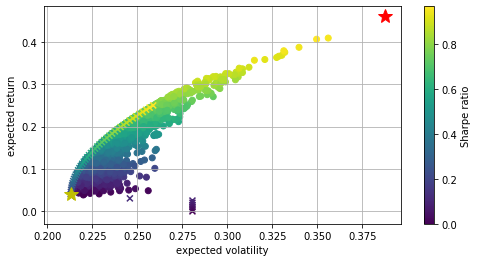

In [37]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o')
            # random portfolio composition
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x')
            # efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0)
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=15.0)
            # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [38]:
#资本市场线
import scipy.interpolate as sci

ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

tck = sci.splrep(evols, erets)

def f(x):
    ''' Efficient frontier function (splines approximation). '''
    return sci.splev(x, tck, der=0)
def df(x):
    ''' First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1)

def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.5, 0.15])

opt

array([0.01      , 1.07417652, 0.30562936])

In [39]:
np.round(equations(opt), 6)

array([ 0., -0.,  0.])

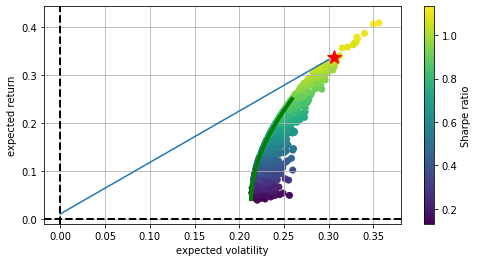

In [40]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
            c=(prets - 0.01) / pvols, marker='o')
            # random portfolio composition
plt.plot(evols, erets, 'g', lw=4.0)
            # efficient frontier
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
            # capital market line
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')


In [41]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

res['x'].round(3)

array([0.649, 0.   , 0.351, 0.   ])